In [5]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
from emtracks.interpolations import *
import matplotlib.animation as animation
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')
import os

testdir = "/home/darren/Desktop/plots/"
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"
date = "/7-9/"
newdir = datadir+'test4/'
%matplotlib notebook

ERROR! Please set $EMTRACKS_DDIR and $EMTRACKS_PDIR. Setting defaults (current directory)


In [6]:
files = sorted(os.listdir(newdir))
e_solvernom = trajectory_solver.from_pickle(newdir+files[0])
f = interp_cole(e_solvernom.dataframe, 13)
e = 10

TypeError: an integer is required (got type bytes)

In [ ]:
def readpkl(zstart, zend, numpoints):
    files = sorted(os.listdir(newdir))
    zsteps = np.linspace(zstart, zend, numpoints)
    data = []

    for file in files:
        x = file.split('_')
        field = float(x[0])
        name = x[4][:3]
        e_solvernom = trajectory_solver.from_pickle(newdir+file)
        phi = e_solvernom.init_conds.phi0
        theta = e_solvernom.init_conds.theta0
        for z in zsteps:
            info = interp_cole(e_solvernom.dataframe, z)
            x = info[1]
            y = info[2]
            r = tuple([(x**2 + y**2)**(1/2)])

            tuple1 = (z, field, theta, phi, name)
            data.append(tuple1 + info + r)
            
    return data 

In [7]:
x = readpkl(6, 13, 8)
df = pd.DataFrame(x, columns = ['z', 'field', 'theta', 'phi', 'name', 't', 'x', 'y', 'r'])

NameError: name 'readpkl' is not defined

In [3]:
e_solvernom = trajectory_solver.from_pickle(newdir+'50.0_1.346_0.256_0.054_nom.pkl')
e_solverdis = trajectory_solver.from_pickle(newdir+'50.0_1.346_0.256_0.054_dis.pkl')

e_solverdis.dataframe['pz'].values.mean() - e_solvernom.dataframe['pz'].values.mean()

NameError: name 'trajectory_solver' is not defined

In [4]:
e_solvernom.DataFrame

NameError: name 'e_solvernom' is not defined

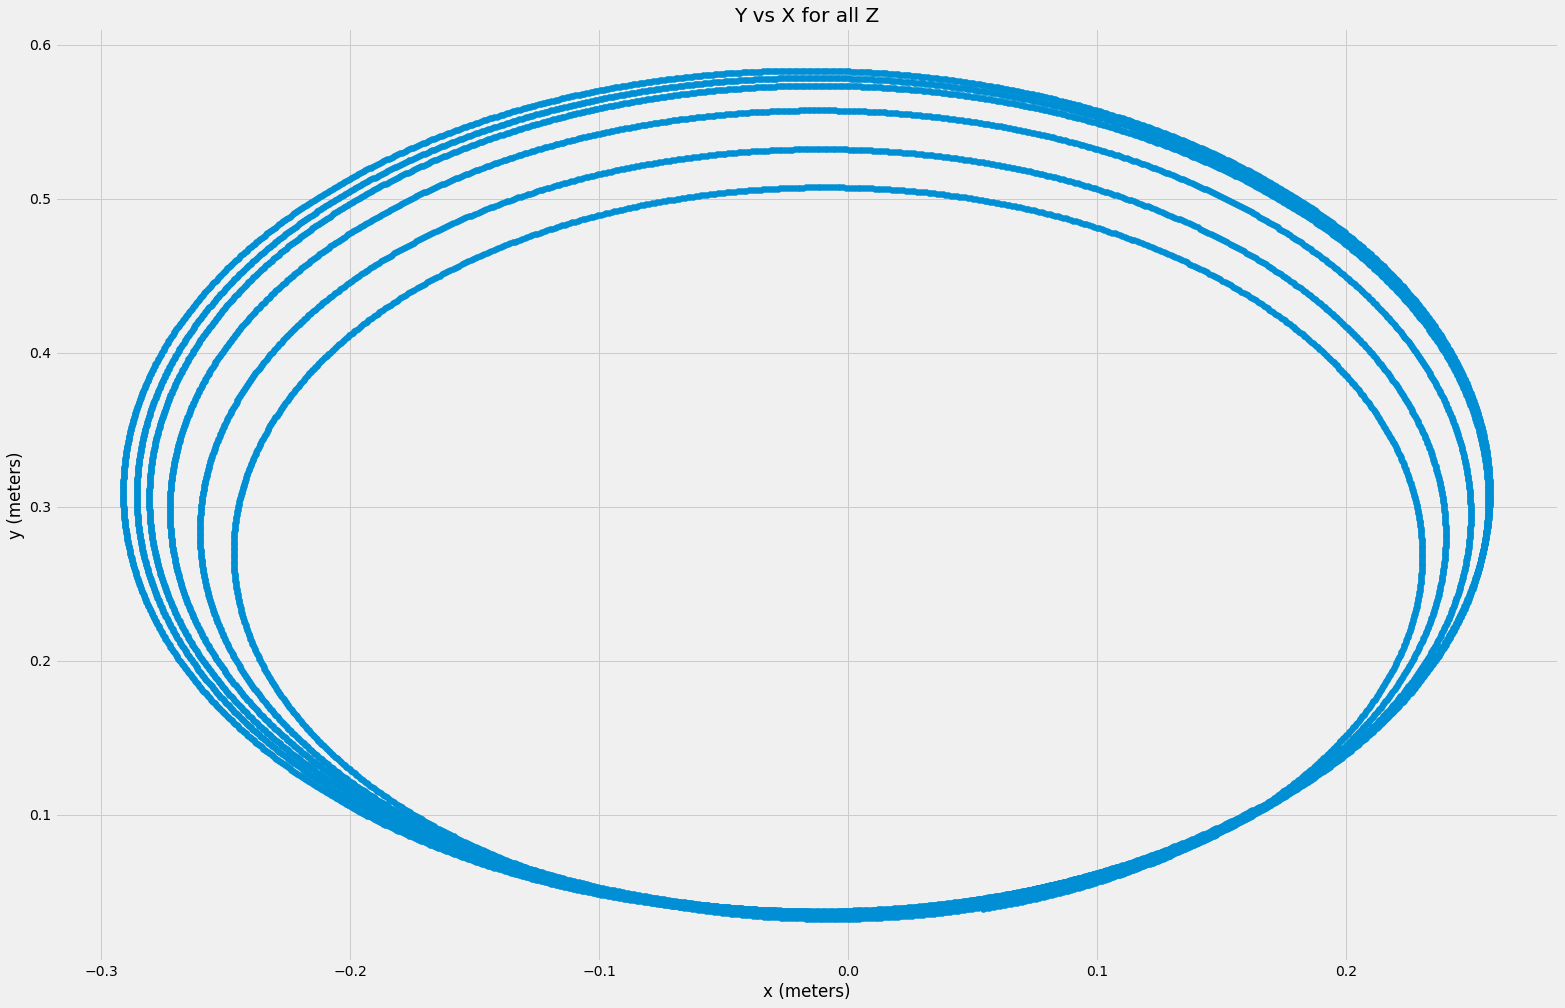

In [30]:
fig = plt.figure()
x = e_solvernom.dataframe['x'].values
y = e_solvernom.dataframe['y'].values
plt.xlabel("x (meters)")
plt.ylabel("y (meters)")
plt.title('Y vs X for all Z')

plt.scatter(x, y)

<function matplotlib.pyplot.show(*args, **kw)>

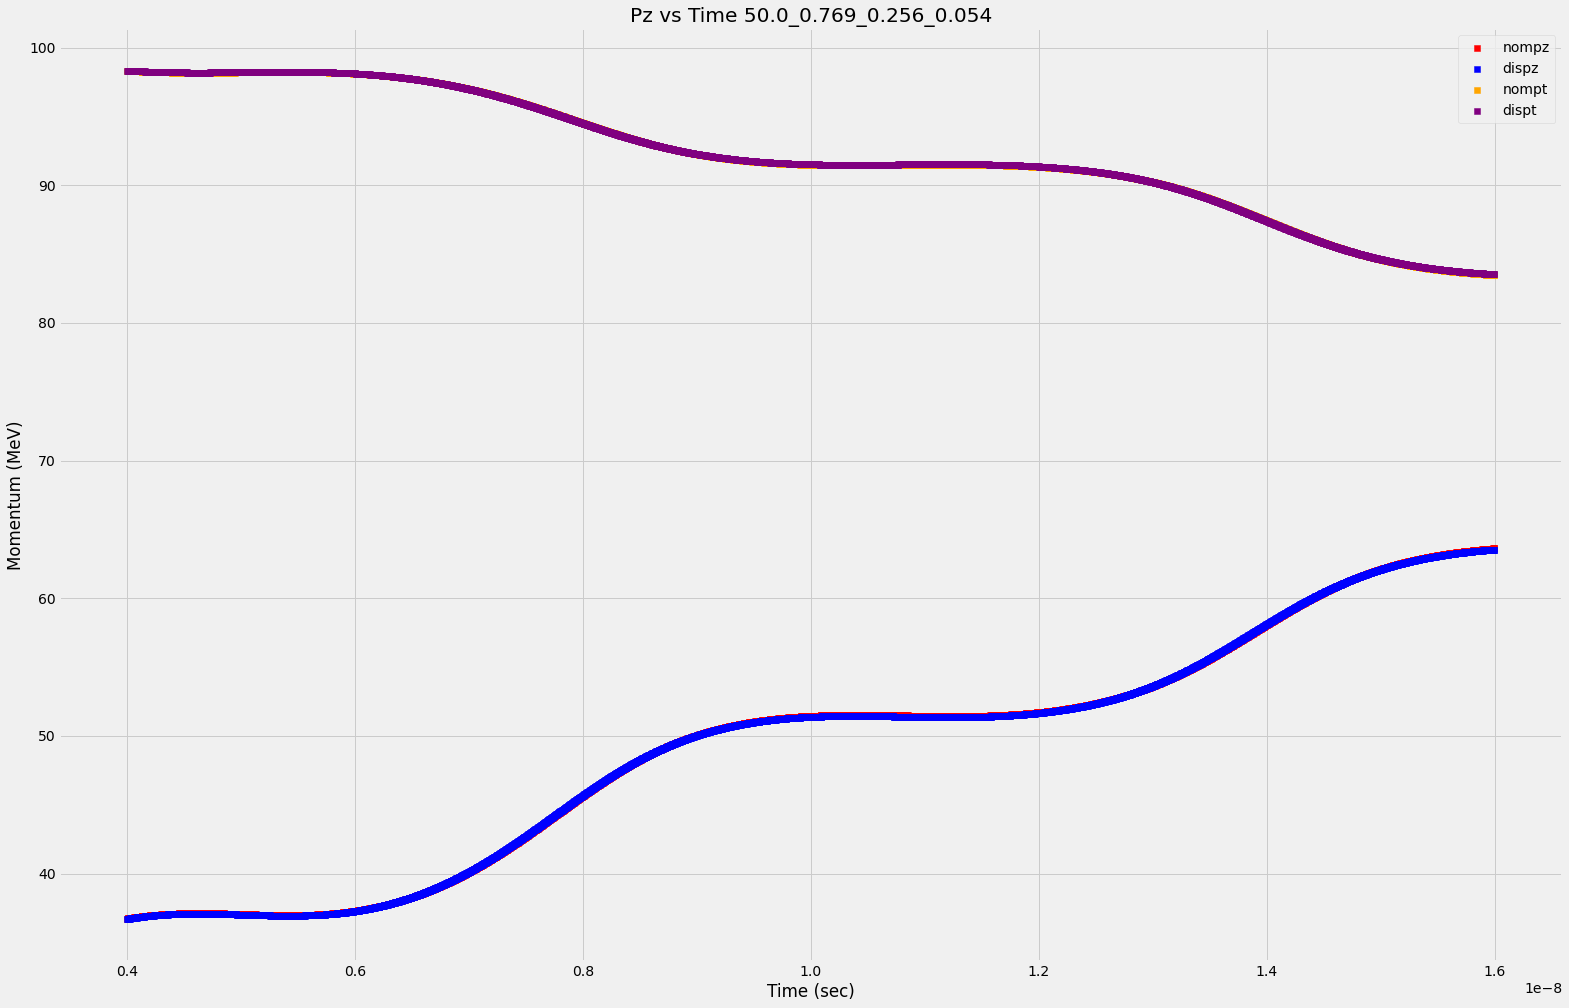

In [12]:
nomt_vals = e_solvernom.dataframe['t'].values[1000:4000]
nompz = e_solvernom.dataframe['pz'].values[1000:4000]
nomp = e_solvernom.dataframe['pz'].values[1000:4000]
nompt = e_solvernom.dataframe['pT'].values[1000:4000]

dist_vals = e_solverdis.dataframe['t'].values[1000:4000]
dispz = e_solverdis.dataframe['pz'].values[1000:4000]
disp = e_solverdis.dataframe['pz'].values[1000:4000]
dispt = e_solverdis.dataframe['pT'].values[1000:4000]

fig = plt.figure()

plt.scatter(nomt_vals, nompz, c='r', marker='s', label='nompz')
plt.scatter(dist_vals, dispz, c='b', marker='s', label='dispz')

plt.scatter(nomt_vals, nompt, c='orange', marker='s', label='nompt')
plt.scatter(dist_vals, dispt, c='purple', marker='s', label='dispt')

plt.title(f'Pz vs Time 50.0_0.769_0.256_0.054')
plt.legend(loc='upper right')
plt.xlabel("Time (sec)")
plt.ylabel("Momentum (MeV)")
plt.show

In [13]:
e_solvernom2 = trajectory_solver.from_pickle(newdir+'50.0_0.064_0.256_0.054_nom.pkl')
e_solverdis2 = trajectory_solver.from_pickle(newdir+'50.0_0.064_0.256_0.054_dis.pkl')

e_solverdis.dataframe['pz'].values.mean() - e_solvernom.dataframe['pz'].values.mean()

-0.04479437523773555

<IPython.core.display.Javascript object>


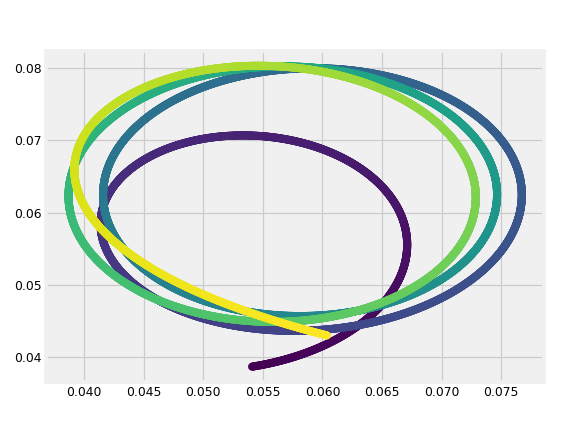

In [40]:
fig = plt.figure()
x = e_solvernom2.dataframe['x'].values
y = e_solvernom2.dataframe['y'].values

plt.scatter(x, y, c = e_solvernom2.dataframe['t'].values)

<function matplotlib.pyplot.show(*args, **kw)>

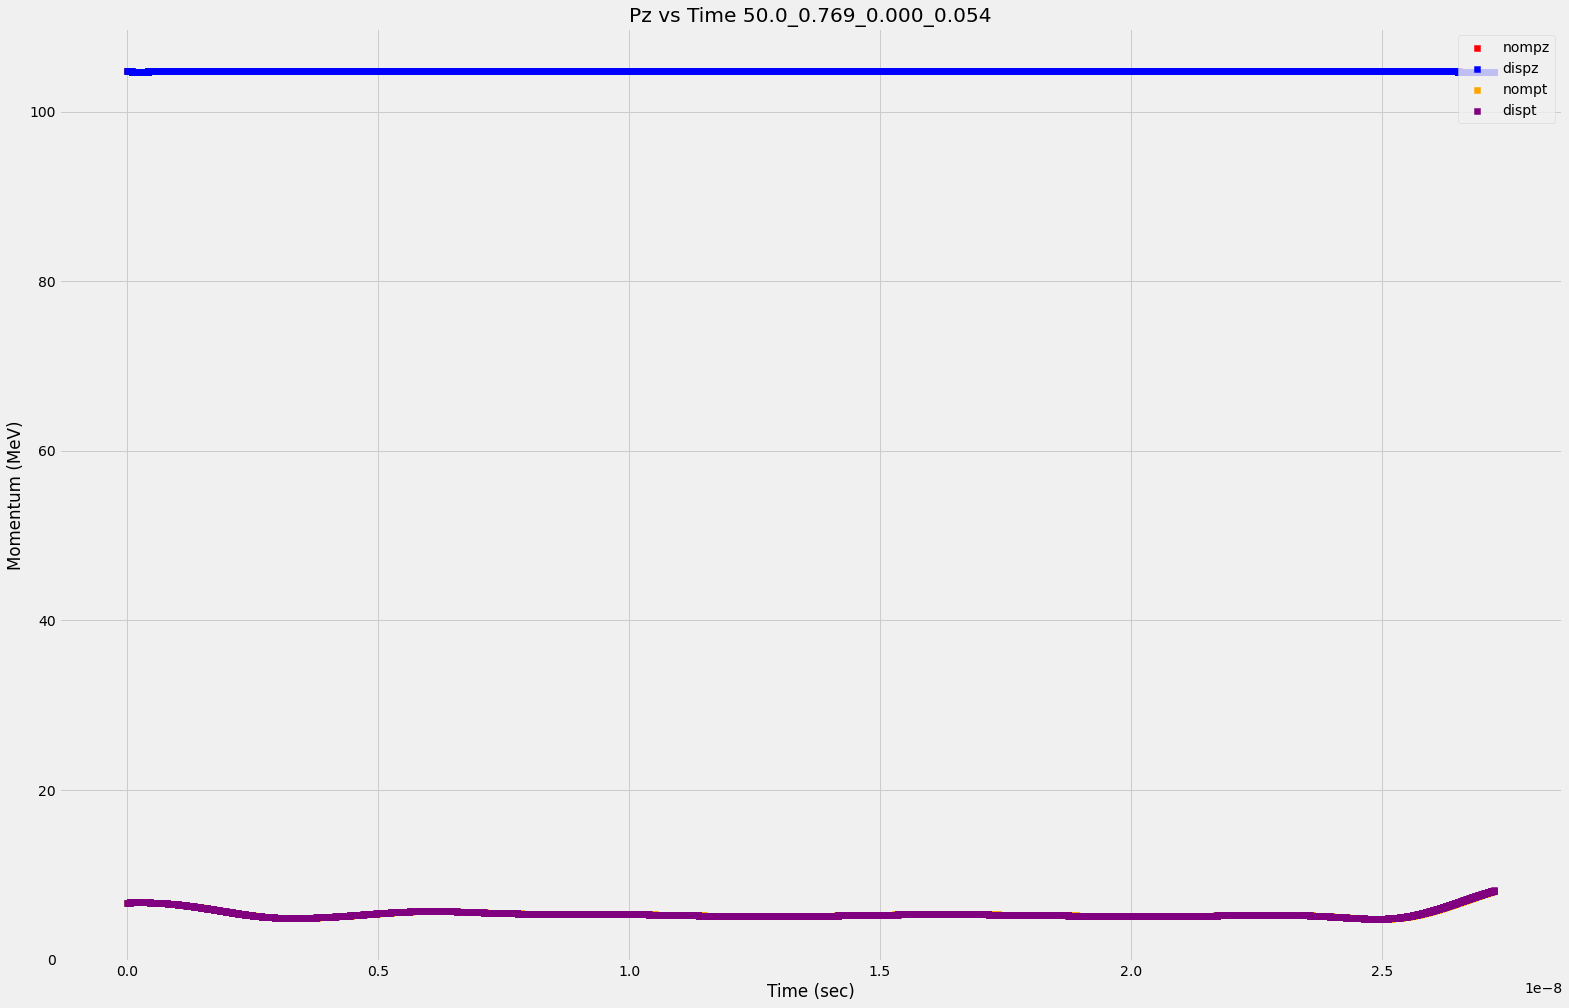

In [15]:
nomt_vals2 = e_solvernom2.dataframe['t'].values
nompz2 = e_solvernom2.dataframe['pz'].values
nomp2 = e_solvernom2.dataframe['pz'].values
nompt2 = e_solvernom2.dataframe['pT'].values

dist_vals2 = e_solverdis2.dataframe['t'].values
dispz2 = e_solverdis2.dataframe['pz'].values
disp2 = e_solverdis2.dataframe['pz'].values
dispt2 = e_solverdis2.dataframe['pT'].values

fig = plt.figure()

plt.scatter(nomt_vals2, nompz2, c='r', marker='s', label='nompz')
plt.scatter(dist_vals2, dispz2, c='b', marker='s', label='dispz')

plt.scatter(nomt_vals2, nompt2, c='orange', marker='s', label='nompt')
plt.scatter(dist_vals2, dispt2, c='purple', marker='s', label='dispt')

plt.title(f'Pz vs Time 50.0_0.769_0.000_0.054')
plt.legend(loc='upper right')
plt.xlabel("Time (sec)")
plt.ylabel("Momentum (MeV)")
plt.show

In [34]:
def gettimedifferences(phi, theta):
    dfnew = df[(df['z']==13.0) & (np.isclose(df['theta'], theta, 1e-2)) & (df['field']==50.0) & (np.isclose(df['phi'], phi, 1e-2))] 
    dfnom = dfnew[dfnew['name']=='nom']
    dfdis = dfnew[dfnew['name']=='dis']
    return (dfnom['t'].values[0] - dfdis['t'].values[0])

In [35]:
np.unique(df['theta'])
np.unique(df['field'])
distances = []
for phi in np.unique(df['phi']):
    for theta in np.unique(df['theta'])[12:22]:
        distances.append(gettimedifferences(phi, theta))

In [36]:
print(np.unique(df['theta'])[12:22])
print(np.unique(df['phi']))

[0.76936963 0.83348377 0.8975979  0.96171204 1.02582617 1.08994031
 1.15405444 1.21816858 1.28228272 1.34639685]
[0.         0.12822827 0.25645654 0.38468481 0.51291309 0.64114136
 0.76936963 0.8975979  1.02582617 1.15405444 1.28228272 1.41051099
 1.53873926 1.66696753 1.7951958  1.92342407 2.05165235 2.17988062
 2.30810889 2.43633716 2.56456543 2.6927937  2.82102197 2.94925025
 3.07747852 3.20570679 3.33393506 3.46216333 3.5903916  3.71861988
 3.84684815 3.97507642 4.10330469 4.23153296 4.35976123 4.48798951
 4.61621778 4.74444605 4.87267432 5.00090259 5.12913086 5.25735913
 5.38558741 5.51381568 5.64204395 5.77027222 5.89850049 6.02672876
 6.15495704 6.28318531]


In [37]:
np.mean(distances)

1.5382131422406124e-11

In [20]:
pos = []
neg = []
for distance in distances:
    if distance > 0:
        pos.append(distance)
    if distance < 0:
        neg.append(distance)
len(pos)

335

In [21]:
def restructure(df, z, fieldval, thetaval):
    olddf = df[(np.isclose(df['theta'], thetaval, 1e-3))&(df['field'] == fieldval)&(df['z']==z)]
    
    nomdata = []
    disdata = []
    uniquephi = np.unique(olddf['phi'])
    uniquez = np.unique(df['z'])

    for phi in uniquephi:
        nomdf = olddf[(olddf['phi']==phi)&(olddf['name']=='nom')]
        disdf = olddf[(olddf['phi']==phi)&(olddf['name']=='dis')]
    
        nomdata.append(nomdf.values.tolist())
        disdata.append(disdf.values.tolist())
        
    #nomdata: zval, field, theta, phi, name, t, x, y, r
    nomphis = []
    nomxs = []
    nomys = []
    nomrs = []

    disphis = []
    disxs = []
    disys = []
    disrs = []

    zval = nomdata[0][0][0]
    fieldval = nomdata[0][0][1]
    thetaval = nomdata[0][0][2]
    
    for i in range(0, len(nomdata), 1):
        nomphis.append(nomdata[i][0][3])
        nomxs.append(nomdata[i][0][6])
        nomys.append(nomdata[i][0][7])
        nomrs.append(nomdata[i][0][8])
    
        disphis.append(disdata[i][0][3])
        disxs.append(disdata[i][0][6])
        disys.append(disdata[i][0][7])
        disrs.append(disdata[i][0][8])
        
    return (uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, disxs, disys, disrs)

In [22]:
uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
disxs, disys, disrs = restructure(df, 9, 50.0, 0.76936963)

uniquez2, zval2, fieldval2, thetaval2, nomphis2, nomxs2, nomys2, nomrs2, disphis2, \
disxs2, disys2, disrs2 = restructure(df, 9, 5.0, 0.76936963)

Text(0, 0.5, 'Y (meters)')

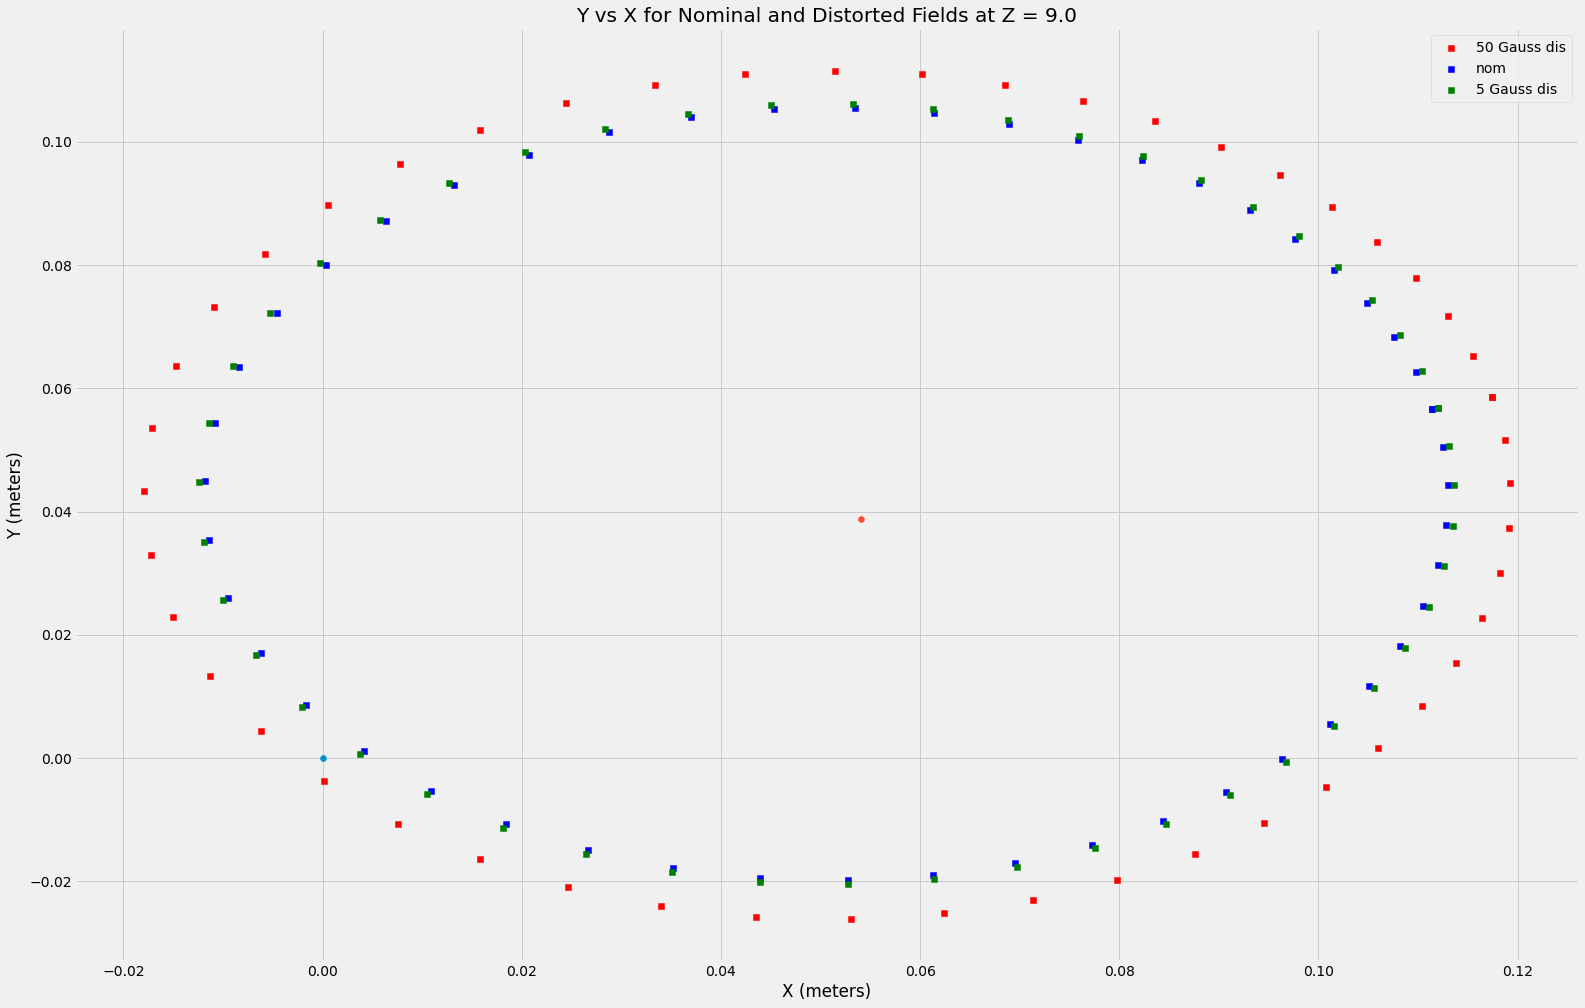

In [23]:
fig1 = plt.figure()
#plt.scatter(nomxs, nomys, c='b', marker='s', label='nom')
plt.scatter(disxs, disys, c='r', marker='s', label='50 Gauss dis')

plt.scatter(nomxs2, nomys2, c='b', marker='s', label='nom')
plt.scatter(disxs2, disys2, c='g', marker='s', label='5 Gauss dis')

plt.scatter(0, 0)
plt.scatter(0.054094482, 0.03873037)

plt.title(f'Y vs X for Nominal and Distorted Fields at Z = {zval}')
plt.legend(loc='upper right')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

In [24]:
uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
disxs, disys, disrs = restructure(df, 12, 50.0, 0.76936963)

uniquez2, zval2, fieldval2, thetaval2, nomphis2, nomxs2, nomys2, nomrs2, disphis2, \
disxs2, disys2, disrs2 = restructure(df, 12, 5.0, 0.76936963)

Text(0, 0.5, 'Y (meters)')

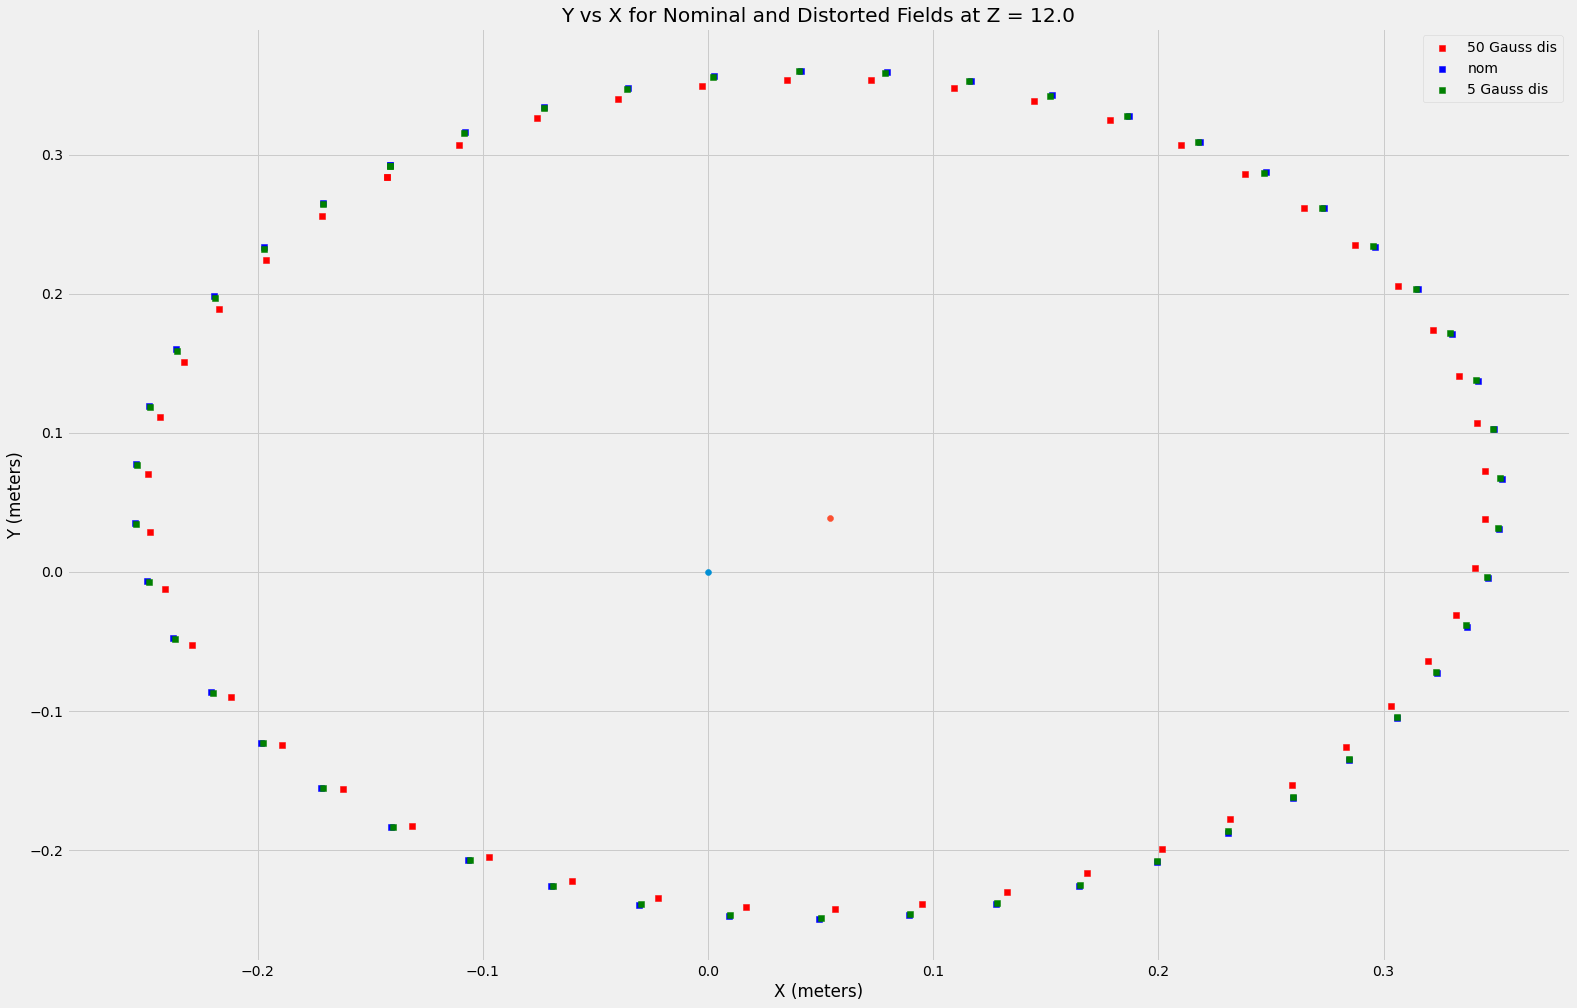

In [25]:
fig2 = plt.figure()
#plt.scatter(nomxs, nomys, c='b', marker='s', label='nom')
plt.scatter(disxs, disys, c='r', marker='s', label='50 Gauss dis')

plt.scatter(nomxs2, nomys2, c='b', marker='s', label='nom')
plt.scatter(disxs2, disys2, c='g', marker='s', label='5 Gauss dis')

plt.scatter(0, 0)
plt.scatter(0.054094482, 0.03873037)

plt.title(f'Y vs X for Nominal and Distorted Fields at Z = {zval}')
plt.legend(loc='upper right')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

<IPython.core.display.Javascript object>


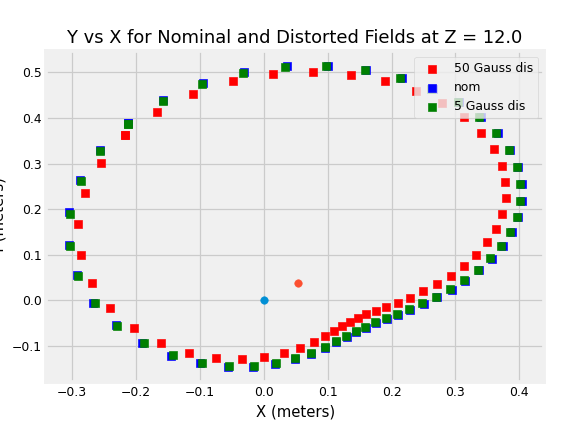

Text(0, 0.5, 'Y (meters)')

In [39]:
uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
disxs, disys, disrs = restructure(df, 12.0, 50.0, 1.346)

uniquez2, zval2, fieldval2, thetaval2, nomphis2, nomxs2, nomys2, nomrs2, disphis2, \
disxs2, disys2, disrs2 = restructure(df, 12.0, 5.0, 1.346)

fig2 = plt.figure()
#plt.scatter(nomxs, nomys, c='b', marker='s', label='nom')
plt.scatter(disxs, disys, c='r', marker='s', label='50 Gauss dis')

plt.scatter(nomxs2, nomys2, c='b', marker='s', label='nom')
plt.scatter(disxs2, disys2, c='g', marker='s', label='5 Gauss dis')

plt.scatter(0, 0)
plt.scatter(0.054094482, 0.03873037)

plt.title(f'Y vs X for Nominal and Distorted Fields at Z = {zval}' )
plt.legend(loc='upper right')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

Text(0, 0.5, 'Y (meters)')

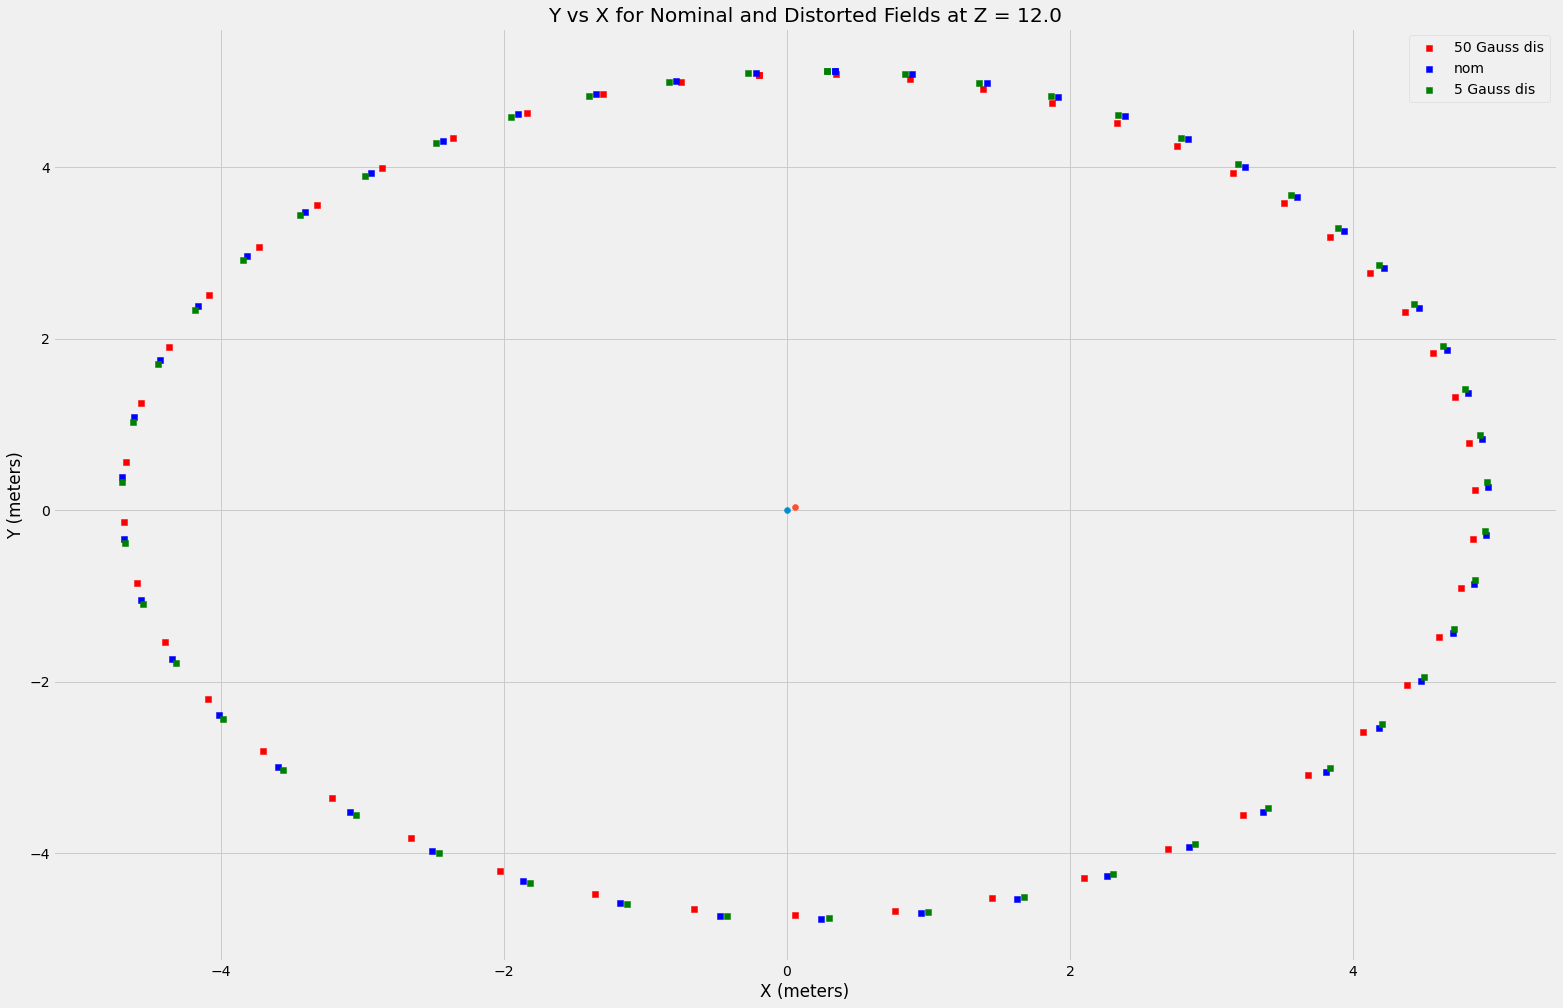

In [33]:
uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
disxs, disys, disrs = restructure(df, 12.0, 50.0, 1.795)

uniquez2, zval2, fieldval2, thetaval2, nomphis2, nomxs2, nomys2, nomrs2, disphis2, \
disxs2, disys2, disrs2 = restructure(df, 12.0, 5.0, 1.795)

fig2 = plt.figure()
#plt.scatter(nomxs, nomys, c='b', marker='s', label='nom')
plt.scatter(disxs, disys, c='r', marker='s', label='50 Gauss dis')

plt.scatter(nomxs2, nomys2, c='b', marker='s', label='nom')
plt.scatter(disxs2, disys2, c='g', marker='s', label='5 Gauss dis')

plt.scatter(0, 0)
plt.scatter(0.054094482, 0.03873037)

plt.title(f'Y vs X for Nominal and Distorted Fields at Z = {zval}' )
plt.legend(loc='upper right')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

[ 6.  7.  8.  9. 10. 11. 12. 13.]


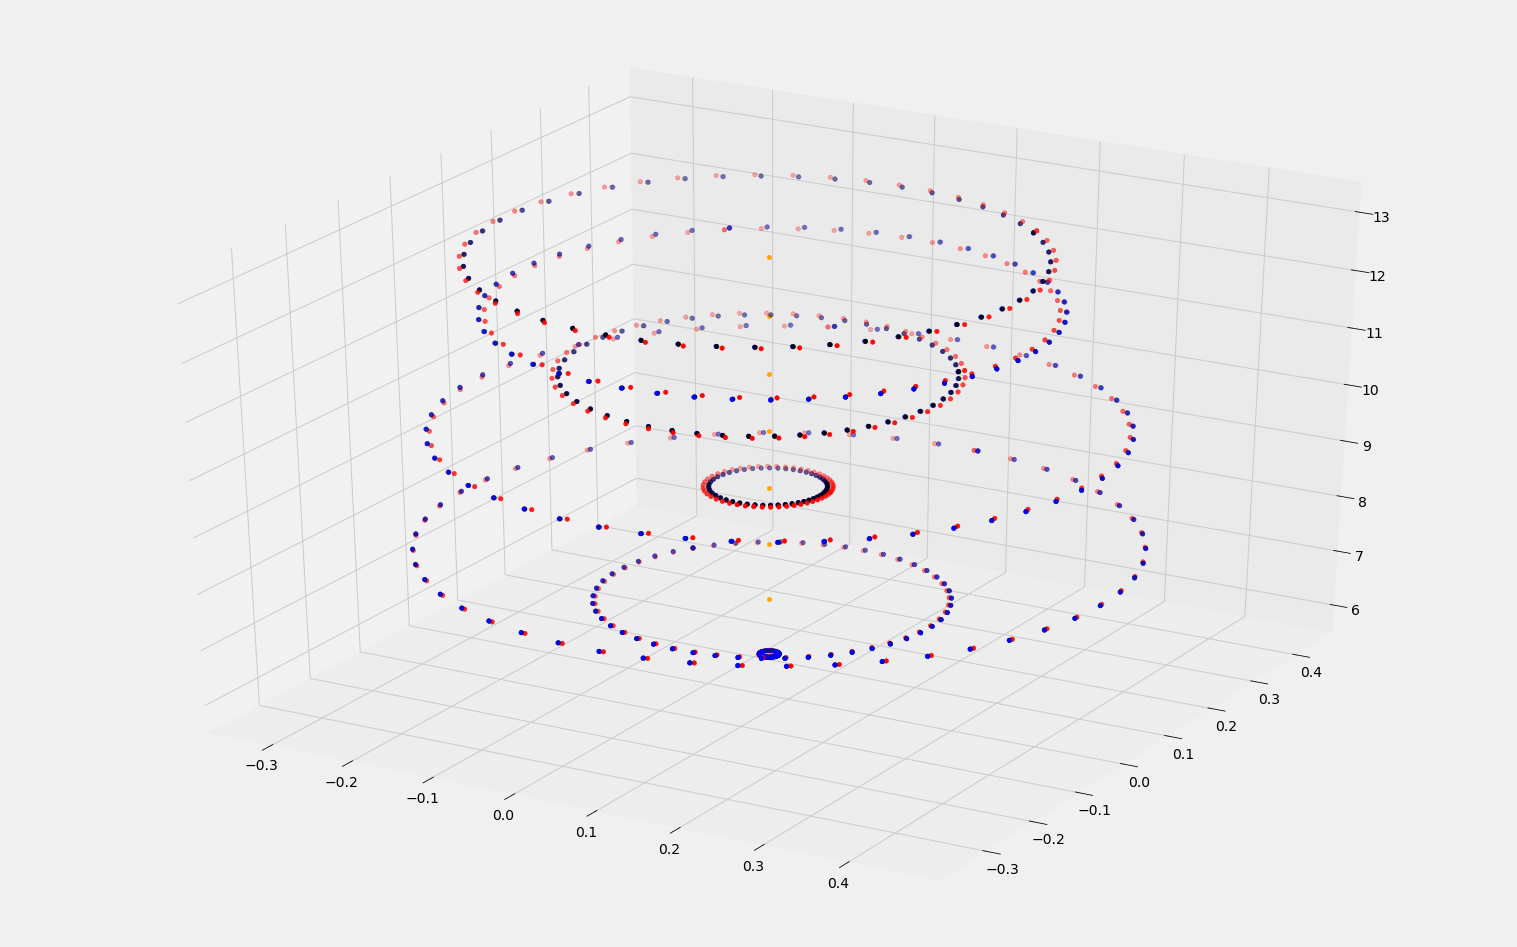

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
print(uniquez)
for i in uniquez:
    
    uniquez, zval, fieldval, thetaval, nomphis, nomxs, nomys, nomrs, disphis, \
    disxs, disys, disrs = restructure(df, i, 50.0, 0.76936963)
    
    ax.scatter(nomxs, nomys, i, c='blue', label='nom')
    ax.scatter(disxs, disys, i, c='red', label='50 Gauss dis')
    
    ax.scatter(0.054094482, 0.03873037, i, c = 'orange')
    
for i in uniquez:
    
    uniquez2, zval2, fieldval2, thetaval2, nomphis2, nomxs2, nomys2, nomrs2, disphis2, \
    disxs2, disys2, disrs2 = restructure(df, i, 5.0, 0.76936963)
    
    #ax.scatter(nomxs, nomys, i, c='black')
    ax.scatter(disxs2, disys2, i, c='black', label='5 Gauss dis')

fig.savefig(datadir+'plot.pdf')
